## Figure 4b
loaded data include the skin conductance over time for each session

In [4]:
## data is read from the recording and save with pickle
with open('all_sessions_all_subj.pkl', 'wb') as f:
    pickle.dump(all_sessions_all_subj, f)
            

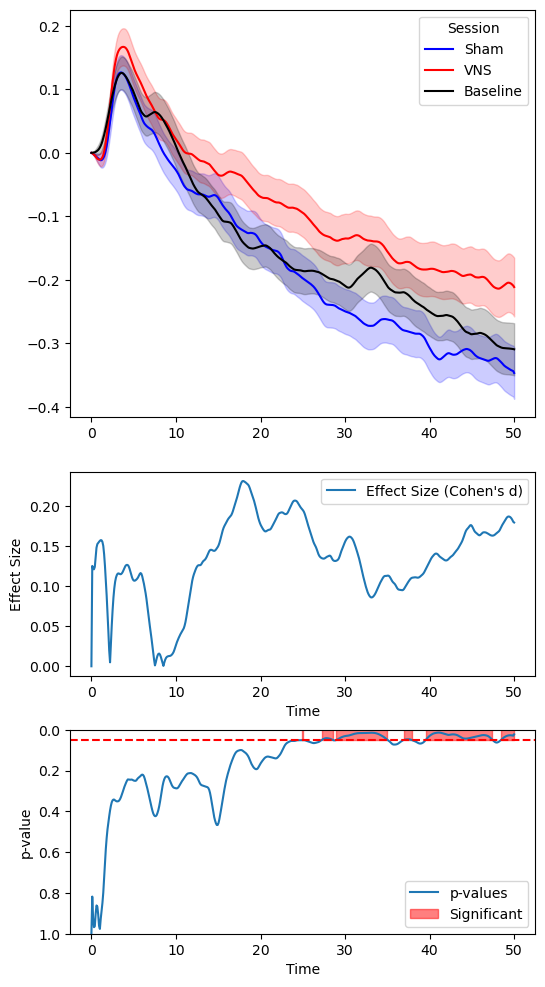

In [8]:
import pickle
with open('all_sessions_all_subj.pkl', 'rb') as f:
    all_sessions_all_subj = pickle.load(f)
    
# Now, plot the original smoothed data
# Create empty lists to store the sc vectors for each session type
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import wilcoxon

from matplotlib.gridspec import GridSpec
def pad_arrays(array_list):
    max_len = max([len(arr) for arr in array_list])
    return np.array([np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=np.nan) for arr in array_list])

sc_sham = []
sc_vns = []
sc_baseline = []

for session, session_data in all_sessions_all_subj.items():
    for data in session_data:
        sc = data['sc']

        idx_start = np.where(data['time'] >= time_start)[0][0]
        idx_end = np.where(data['time'] <= time_end)[0][-1]
        time = data['time'][idx_start: idx_end + 1]
        sc_trunc = sc[idx_start: idx_end + 1]

        sc_01 = (sc_trunc - np.nanmin(sc_trunc)) / (np.nanmax(sc_trunc) - np.nanmin(sc_trunc))
        sc_01 = sc_01 - sc_01[0]
        if session == 'sham':
            sc_sham.append(sc_01)
        elif session == 'VNS':
            sc_vns.append(sc_01)
        elif session == 'baseline':
            sc_baseline.append(sc_01)
            
        data2df = pd.DataFrame({
            'time': time,
            'sc': sc_01,
            'n': data['n'],
            'session': session,
            'study_id': data['study_id'],
        })


sc_sham = pad_arrays(sc_sham)
sc_vns = pad_arrays(sc_vns)
sc_baseline = pad_arrays(sc_baseline)

mean_sham = np.nanmean(sc_sham, axis=0)
mean_vns = np.nanmean(sc_vns, axis=0)
mean_baseline = np.nanmean(sc_baseline, axis=0)

se_sham = np.nanstd(sc_sham, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(sc_sham), axis=0))
se_vns = np.nanstd(sc_vns, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(sc_vns), axis=0))
se_baseline = np.nanstd(sc_baseline, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(sc_baseline), axis=0))




p_values = []
z_values = []
effect_sizes = []

# Conduct t-tests at each time point
for i in range(len(time)):
    vns_data = sc_vns[:, i]
    baseline_data = sc_baseline[:, i]
    sham_data = sc_sham[:, i]


    
    valid_indices = ~np.isnan(vns_data) & ~np.isnan(sham_data)
    vns_data = vns_data[valid_indices]
    sham_data = sham_data[valid_indices]
    
    # paired t-test
    t_stat, p_val = ttest_ind(vns_data, sham_data)
    if np.all(vns_data - sham_data == 0):
        p_values.append(1) 
        effect_sizes.append(0)
        continue

    
    p_values.append(p_val)

    pooled_sd = np.sqrt((np.std(vns_data, ddof=1)**2 + np.std(baseline_data, ddof=1)**2) / 2)
    d = abs(np.mean(vns_data) - np.mean(baseline_data)) / pooled_sd
    effect_sizes.append(d)

gs = GridSpec(3, 1, height_ratios=[2, 1, 1])  # 3:1:1 ratio for heights

fig = plt.figure(figsize=[6, 12])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

time = np.linspace(0, (time_end - time_start) * resfreq, (time_end - time_start) * resfreq ) / resfreq  


ax1.plot(time, mean_sham, label='Sham', color='b')
ax1.fill_between(time, mean_sham - se_sham, mean_sham + se_sham, color='b', alpha=0.2)

ax1.plot(time, mean_vns, label='VNS', color='r')
ax1.fill_between(time, mean_vns - se_vns, mean_vns + se_vns, color='r', alpha=0.2)

ax1.plot(time, mean_baseline, label='Baseline', color='black')
ax1.fill_between(time, mean_baseline - se_baseline, mean_baseline + se_baseline, color='black', alpha=0.2)

ax1.legend(title='Session')

ax2.plot(time, effect_sizes, label='Effect Size (Cohen\'s d)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Effect Size')
ax2.legend()


ax3.plot(time, p_values, label='p-values')

ax3.fill_between(time, -0.05, 0.05, where=(np.array(p_values) < 0.05), color='r', alpha=0.5, label='Significant')
ax3.axhline(0.05, color='r', linestyle='--')  # Significance level
ax3.set_xlabel('Time')
ax3.set_ylabel('p-value')
ax3.set_ylim([0, 1])

ax3.legend()
ax3.invert_yaxis() 

plt.show()


## Figure 4c

/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_193/2381401802.py:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=agg_data_df[agg_data_df['time_interval'] == time_interval],
/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_193/2381401802.py:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=agg_data_df[agg_data_df['time_interval'] == time_interval],
/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_193/2381401802.py:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=agg_data_df[agg_data_df['time_interval'] == time_interval],


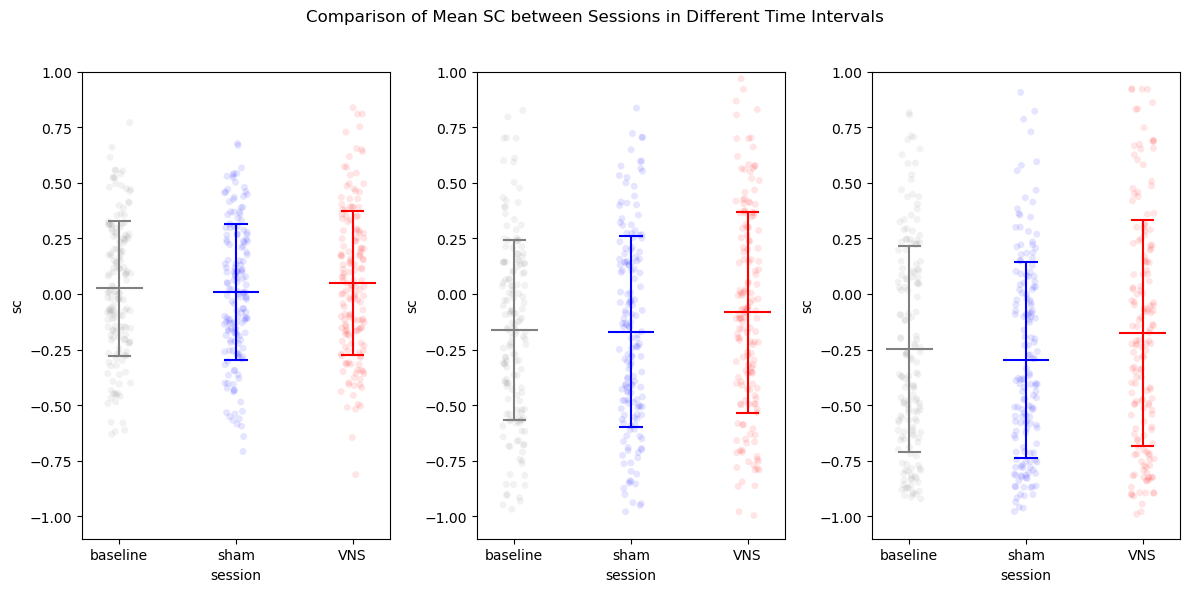

In [14]:
from scipy import stats
agg_data_df = pd.DataFrame()

bins = [0, 15, 30, 50]
labels = ['[0, 15]', '[15, 30]', '[30, 50]']

for session, sc_list in zip(['sham', 'VNS', 'baseline'], [sc_sham, sc_vns, sc_baseline]):
    for sc_01 in sc_list:
        time = np.linspace(time_start, time_end, len(sc_01))  # Assuming time is linearly spaced
        data2df = pd.DataFrame({
            'time': time,
            'sc': sc_01,
            'session': [session]*len(time),
        })
        

        data2df['time_interval'] = pd.cut(data2df['time'], bins=bins, labels=labels, right=False)
        mean_sc = data2df.groupby(['session', 'time_interval'])['sc'].mean().reset_index()
        
        agg_data_df = pd.concat([agg_data_df, mean_sc])


plt.figure(figsize=(12, 6))

palette = {'VNS': 'red', 'sham': 'blue', 'baseline': 'grey'}

for idx, time_interval in enumerate(agg_data_df['time_interval'].unique()[:3]):
    ax = plt.subplot(1, 3, idx + 1)

    plt.ylim([-1.1, 1])

    sns.stripplot(data=agg_data_df[agg_data_df['time_interval'] == time_interval], 
                  x='session',
                  y='sc', 
                  jitter=0.1, 
                  alpha=0.1, 
                  size=5,
                  ax=ax, 
                  palette=palette, 
                  order=['baseline', 'sham', 'VNS'])

    for i, session in enumerate(['baseline', 'sham', 'VNS']):
        session_data = agg_data_df[(agg_data_df['time_interval'] == time_interval) & (agg_data_df['session'] == session)]
        mean_value = session_data['sc'].mean()
        se_value = stats.sem(session_data['sc'].dropna())  # Calculating the standard error
        se_value = np.std(session_data['sc'].dropna())  # Calculating the standard error
        ax.hlines(mean_value, xmin=i - 0.2, xmax=i + 0.2, color=palette[session], linestyle='-')
        ax.hlines(mean_value + se_value, xmin=i - 0.1, xmax=i + 0.1, color=palette[session], linestyle='-')
        ax.hlines(mean_value - se_value, xmin=i - 0.1, xmax=i + 0.1, color=palette[session], linestyle='-')
        ax.vlines(x=i, ymin=mean_value - se_value, ymax=mean_value + se_value, color=palette[session])


plt.suptitle('Comparison of Mean SC between Sessions in Different Time Intervals')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



## Figure 4d

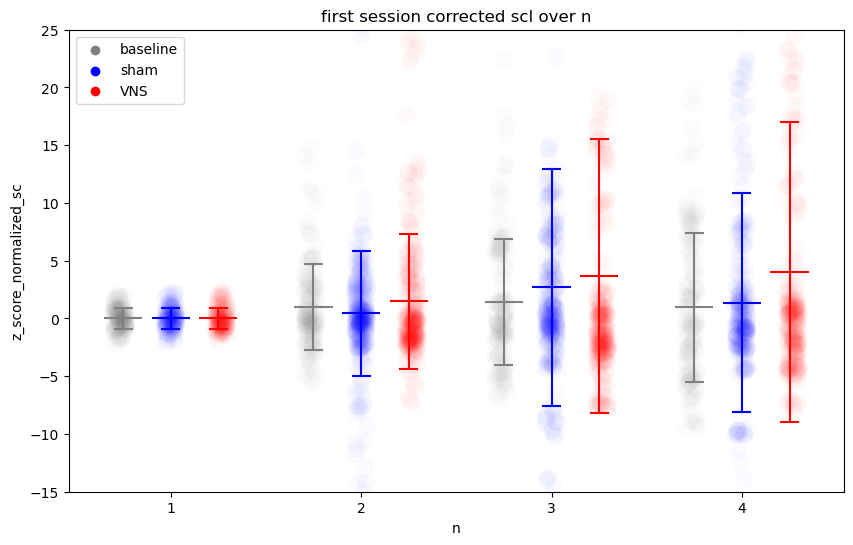

In [17]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def cohen_d(group1, group2):
    """
    Compute Cohen's d.
    
    Args:
        group1: Series or NumPy array
        group2: Series or NumPy array
    Returns:
        d (float): effect size
    """
    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2 - 2)

    d = diff / np.sqrt(pooled_var)
    
    return d

with open('df_scl.pkl', 'rb') as f:
    final_df = pickle.load(f)
    
custom_palette = {'VNS': 'red', 'sham': 'blue', 'baseline': 'grey'}

hue_order = ['baseline', 'sham', 'VNS']
plt.figure(figsize=(10, 6))
plt.ylim([-15, 25])



sns.stripplot(x='n', y='z_score_normalized_sc', hue='session', data=final_df, jitter=True, dodge=True, 
              marker='o', alpha=0.02, size=13, palette=custom_palette, hue_order=hue_order)

for i, n in enumerate([1, 2, 3, 4]):
    for j, session in enumerate(['baseline', 'sham', 'VNS']):
        session_data = final_df[(final_df['n'] == n) & (final_df['session'] == session)]
        mean_value = session_data['z_score_normalized_sc'].mean()
        std_value = stats.sem(session_data['z_score_normalized_sc'].dropna()) 
        std_value = np.std(session_data['z_score_normalized_sc'].dropna())  
        
        x_position = i + (j - 1) * 0.25  
        
        plt.hlines(mean_value, xmin=x_position - 0.1, xmax=x_position + 0.1, color=custom_palette[session], linestyle='-')
        plt.hlines(mean_value + std_value, xmin=x_position - 0.05, xmax=x_position + 0.05, color=custom_palette[session], linestyle='-')
        plt.hlines(mean_value - std_value, xmin=x_position - 0.05, xmax=x_position + 0.05, color=custom_palette[session], linestyle='-')

        plt.vlines(x=x_position, ymin=mean_value - std_value, ymax=mean_value + std_value, color=custom_palette[session])

plt.legend(loc='best')
plt.title('first session corrected scl over n')

plt.show()


## Figure 4e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


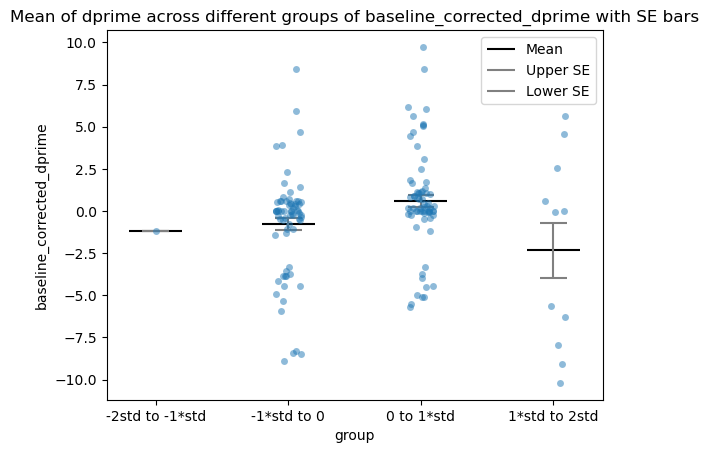

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


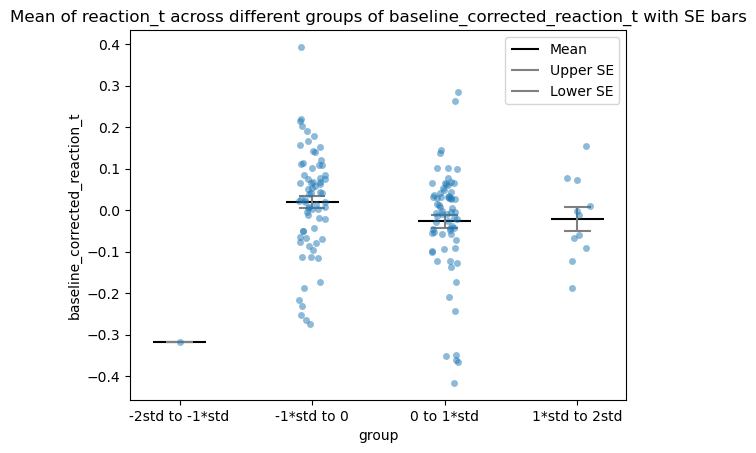

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


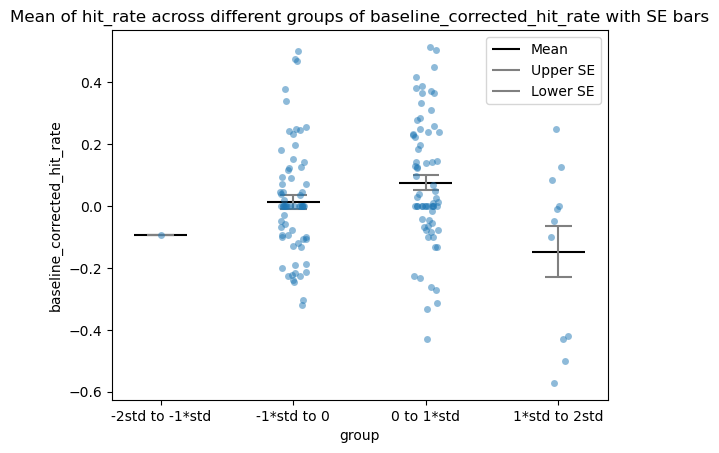

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


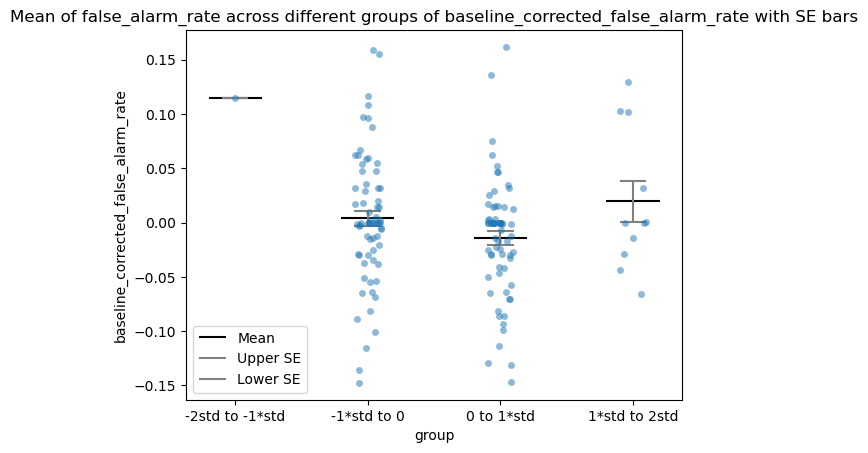

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import itertools

def permutation_test_ttest(group1_data, group2_data, num_permutations=1000):
    n1 = len(group1_data)
    n2 = len(group2_data)
    all_data = np.concatenate([group1_data, group2_data])
    observed_t_stat, _ = stats.ttest_ind(group1_data, group2_data)
    permuted_t_stats = []

    for _ in range(num_permutations):
        np.random.shuffle(all_data)
        perm_group1 = all_data[:n1]
        perm_group2 = all_data[n1:]
        perm_t_stat, _ = stats.ttest_ind(perm_group1, perm_group2)
        permuted_t_stats.append(perm_t_stat)

    p_val_permutation = np.sum(np.abs(permuted_t_stats) >= np.abs(observed_t_stat)) / num_permutations
    return p_val_permutation

with open('df_scl_performance.pkl', 'rb') as f:
    df_corr = pickle.load(f)

mean_val = df_corr['scl_baseline_corrected_z_mean'].mean()
std_val = df_corr['scl_baseline_corrected_z_mean'].std()

bins = [-2*std_val, -1*std_val, 0, 1*std_val, 2*std_val]


labels = ['-2std to -1*std', '-1*std to 0', '0 to 1*std', '1*std to 2std']

df_corr['group'] = pd.cut(df_corr['scl_baseline_corrected_z_mean'], bins=bins, labels=labels, right=True)

se_bar_width = 0.1
mean_bar_width = 0.2
# Metrics to analyze
columns_to_analyze = ['dprime', 'reaction_t',  'hit_rate', 'false_alarm_rate']

for col in columns_to_analyze:
    plt.figure()

    plt.title(f'Mean of {col} across different groups of scl_baseline_corrected_mean with SE bars')
    sns.stripplot(x='group', y='baseline_corrected_' + col, data=df_corr, jitter=True, alpha=0.5)

    df_corr_2plot = df_corr.copy()
    df_corr_2plot = df_corr_2plot.dropna(subset=['group'])
    groups =['-2std to -1*std', '-1*std to 0', '0 to 1*std', '1*std to 2std']

    means = []
    std_errs = []
    for idx, group in enumerate(groups):
        group_data = df_corr_2plot[df_corr_2plot['group'] == group]['baseline_corrected_' + col]
        group_mean = np.mean(group_data)
        group_std_err = np.std(group_data) / np.sqrt(len(group_data))
        upper_se = group_mean + group_std_err
        lower_se = group_mean - group_std_err

        plt.hlines(y=group_mean, xmin=idx-mean_bar_width, xmax=idx+mean_bar_width, color='black', label='Mean' if idx==0 else "")
        plt.hlines(y=group_mean + group_std_err, xmin=idx-se_bar_width, xmax=idx+se_bar_width, color='grey', linestyle='-', label='Upper SE' if idx==0 else "")
        plt.hlines(y=group_mean - group_std_err, xmin=idx-se_bar_width, xmax=idx+se_bar_width, color='grey', linestyle='-', label='Lower SE' if idx==0 else "")

        plt.vlines(x=idx, ymin=lower_se, ymax=upper_se, color='grey', linestyle='-')
        
            plt.title(f'Mean of {col} across different groups of baseline_corrected_{col} with SE bars')
    plt.legend()

    plt.title(f'Mean of {col} across different groups of baseline_corrected_{col} with SE bars')
    plt.legend()
    

    plt.savefig(filename, format='eps')
    plt.show()

